In [3]:
import pandas as pd
from src.new.newtests import test_speeds, sprinkler_pts, test_joint_prob

# Code changes

The new updates fix the quantum circuits and replace the QSearch with a calculation of the probability of the evidence P(E) to calculate the optimal number of Grover iterations for the circuit. 

Additionally, a qiskitless version is created by calculating the Grover circuit probabilities analytically and adding shot noise. 

This allows for much faster execution of the algorithms.

This notebook illustrates the changes and main additions, using a simple example (cloudy-sprinkler-rain-wetgrass).

## Speed comparison

In [4]:
test_speeds(Nruns = 10, Nsamples = 10)

> Testing speed for quantum Bayesian network queries.
* Old code
> Time elapsed: 0.10338221189996694ms.
  (To be used as reference.)
* New code
> Time elapsed: 0.012964831400022376ms.
  (8.0x faster than the reference.)
* New (no Qiskit) code
> Time elapsed: 0.001974662199965678ms.
  (52.4x faster than the reference.)


The speed-up is largely enabled by the calculation of the joint probability P(e) from data structures we have access to (CPTs and topological order). P(e) is the amplitude; using it, we can calculate the optimal number of Grover iterations, dispensing with the exponential QSearch and using a fixed circuit. Furthermore, this allows us to simulate the quantum sampling classically, because we can calculate the amplified success rate (lower rejection). We can then forgo Qiskit.   

## Joint probability calculation

Let's consider the sprinkler example.



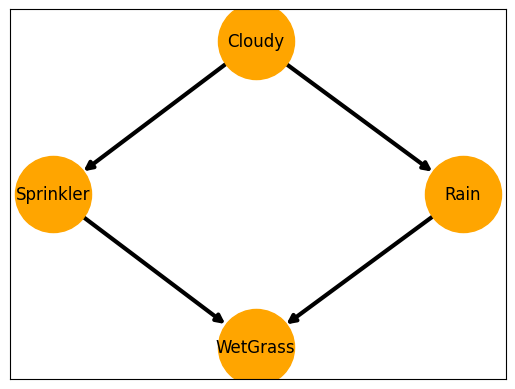

In [1]:
from src.new.newtests import init_problem_bn

bn = init_problem_bn()
bn.draw()

The CPTS we have are $P(C)$, $P(S|C)$, $P(R|C)$, $P(W|S,R)$. 

In [4]:
def print_cpts(cpts_dict):
    for name in cpts_dict.keys():
        a = name[0]
        d = cpts_dict[name]
        parents = [p[0] for p in d.keys() if p != "Prob" and p!=name]
        cond = ("|" + ",".join(parents)) if len(parents)>0 else ""
        print(f"*P({a}{cond}):")
        df = pd.DataFrame(d)
        print(df)

d = sprinkler_pts(simpler = False)
print_cpts(d)

*P(C):
   Cloudy  Prob
0       0   0.5
1       1   0.5
*P(S|C):
   Cloudy  Sprinkler  Prob
0       0          0   0.5
1       0          1   0.5
2       1          0   0.9
3       1          1   0.1
*P(R|C):
   Cloudy  Rain  Prob
0       0     0   0.8
1       0     1   0.2
2       1     0   0.2
3       1     1   0.8
*P(W|S,R):
   Sprinkler  Rain  WetGrass  Prob
0          0     0         0  1.00
1          0     0         1  0.00
2          0     1         0  0.10
3          0     1         1  0.90
4          1     0         0  0.10
5          1     0         1  0.90
6          1     1         0  0.01
7          1     1         1  0.99


The most complicated case where we have to calculate joint probabilities is when some variables are not specified. 

For instance, $P(C = 1, R = 1, S = 1, W = 0)$ is straightforward. We can use:


$$P(x_1, \dots, x_N) = \prod_N P(x_i | parents(X_i))$$

But for joint probabilities like $P(C = 1, R = 1, W = 0)$, we must marginalize over the variable that is not present. We cannot calculate $$P(C=1)P(R=1|C=1)P(W=0|R=1,C=1)$$ because we don't have $P(W|C,R)$, only $P(W|S,R)$. So we have to sum over values of the absent variable(s):

$$P(C = 1, R = 1, W = 0) = \sum_{s \in \{0,1\}} P(C=1)P(R=1|C=1)P(W=0|R=1,S=s)P(S=s|C=1)$$

$$ = 0.5 \times 0.8 \times (0.9 \times 0.1 + 0.1 \times 0.01) = 0.364

In [5]:
ev = {"Cloudy": 1, "Rain": 1, "WetGrass": 0}
test_joint_prob(ev)

Sprinkler
Calculated joint probability: 0.03640000000000001


We create a function that calculates the joint probability of an arbitrary subset of variables given the topological order and the CPTs (both of which we have). 

We have to multiply the conditional probabilities of each node and multiply them. To calculate the conditional probability of a node:
* If there are no unspecified parents, look up the CPT.
* If there are, pick the unspecified parent that is highest in the topological order. Calculate the conditional probability of this parent P given all the other specified variables, for each of its possible values.
* Recursively multiply these probabilities for each value of P by the conditional probability of the original node assuming the value for P. 
* This won't terminate if there is more than one parent for each node. So we only consider a parent as unspecified if there hasn't already been a specified parent that was at the same level or higher in the topological order. Any possible path should give the same result if the probability distribution is correct.